import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.neighbors import KernelDensity
import scipy.stats as st
import glob
import os

class Batch_Read():
    def __init__(self, data_path, ref_suffix=None, data_suffix=None):
        self.data_path = glob.glob(data_path)[0]
        self.file_list = os.listdir(self.data_path)
        self.ref_suffix = ref_suffix
        self.data_suffix = data_suffix
        
    def pair_data_ref(self):
        ref_suffix = self.ref_suffix
        file_list = self.file_list
        data = []
        ref = []
        if ref_suffix is not None:
            ref_len = len(ref_suffix)
            for item in file_list:
                if item[-len(ref_suffix)-4:-4] == ref_suffix:
                    ref.append(item)  
                elif ref_suffix not in item:
                    data.append(item)
        elif ref_suffix is None:
            ref_len = 0
            for item in file_list:
                if item[-7:-4] == 'ref':
                    ref.append(item)  
                elif 'ref' not in item:
                    data.append(item)
        if len(ref) != len(data):
            return 'data and ref number not matched'

        data_ref = []
        for i in range(len(data)):
            if ref_len == 0:
                ref_prefix = ref[i][:-8]
            else:
                ref_prefix = ref[i][:-ref_len-5]

            if ref_prefix in data[i]:
                data_ref.append((data[i], ref[i]))
        if len(data_ref) == len(data):
            return data_ref
        else:
            return 'data and ref name not matched'

    def rename_data_ref(self, data_suffix=None, new_data_suffix=None, new_ref_suffix=None, ref_suffix=None, change_name=False):
        file_list = self.file_list
        if ref_suffix is None:
            ref_suffix = self.ref_suffix
        if data_suffix is None:
            data_suffix = self.data_suffix
        if ref_suffix is None:
            return 'Please specify ref suffix'
        if data_suffix is None:
            return 'Please specify data suffix'
        
        old_data_name = []
        old_ref_name = []
        for item in file_list:
            if ref_suffix in item:
                old_ref_name.append(item)
            elif data_suffix in item:
                old_data_name.append(item)
        if len(old_ref_name) != len(old_data_name):
            return 'data and ref number not matched'
        
        old_new_data_name=[]
        old_new_ref_name=[]
        for i in range(len(old_data_name)):
            data_name_root = old_data_name[i].replace(data_suffix, '')
            ref_name_root = old_ref_name[i].replace(ref_suffix, '')
            if data_name_root != ref_name_root:
                return f'{i} {data_name_root} and {ref_name_root} do not match'
            new_data_name = old_data_name[i].replace(data_suffix, new_data_suffix)
            new_ref_name = old_ref_name[i].replace(ref_suffix, new_ref_suffix)
            old_new_data_name.append((old_data_name[i], new_data_name))
            old_new_ref_name.append((old_ref_name[i], new_ref_name))

        if change_name is True:
            for old_new in old_new_data_name:
                os.rename(f'{self.data_path}\\{old_new[0]}',f'{self.data_path}\\{old_new[1]}')
            for old_new in old_new_ref_name:
                os.rename(f'{self.data_path}\\{old_new[0]}',f'{self.data_path}\\{old_new[1]}')
                
        return old_new_data_name, old_new_ref_name
        
class Syn_Position(): #position data exported from imaris
    #ref file should contain at least 3 points, 
    #the first one is the original point,
    #the second one defines the midline,
    #the third one determines the side of interest
    def __init__(self, data_path, filename, refname=None, ref_suffix=None):
        self.data_path = data_path
        self.filename = filename
        self.refname = refname
        self.ref_suffix = ref_suffix
        
    def read_raw_data(self):
        data_filepath = glob.glob(self.data_path +'\\'+ '*' + self.filename)
        filename_suffix = self.filename[-3:]
        if filename_suffix == 'xls':
            data = pd.read_excel(data_filepath[0], header=None, names=['y','x'], skiprows=2, usecols=[0,1])
        elif filename_suffix == 'csv':
            data = pd.read_csv(data_filepath[0], header=None, names=['y','x'], skiprows=4, usecols=[0,1])
        else:
            return 'Only read xls or csv file'
        return data
    
    def read_raw_ref(self, ref_suffix=None):
        ref_filepath = glob.glob(self.data_path +'\\'+ '*' + self.refname)
        if ref_suffix is None:
            ref_suffix = self.ref_suffix
        if self.ref_suffix is None:
            ref_suffix = self.refname[-7:]
        if 'ref' not in ref_suffix:
            print('check if ref is correct')
        if '.xls' in self.refname:
            ref = pd.read_excel(ref_filepath[0], header=None, names=['y','x'], skiprows=2, usecols=[0,1])
        elif '.csv' in self.refname:
            ref = pd.read_csv(ref_filepath[0], header=None, names=['y','x'], skiprows=4, usecols=[0,1])
        else:
            return 'Only read xls or csv ref'
        return ref
    
    def read_nor_data(self):
        data_filepath = glob.glob(self.data_path +'\\'+ '*' + self.filename)
        filename_suffix = self.filename[-7:]
        if filename_suffix == 'nor.xls':
            data = pd.read_excel(data_filepath[0], header=None, names=['x','y'], usecols=[0,1])
        elif filename_suffix == 'nor.csv':
            data = pd.read_csv(data_filepath[0], header=None, names=['x','y'], usecols=[0,1])
        else:
            return 'Only read xls or csv file'
        return data
    
    def read_nor_ref(self):
        ref_filepath = glob.glob(self.data_path +'\\'+ '*' + self.refname)
        refname_suffix = self.refname[-11:]
        if refname_suffix == 'ref_nor.xls':
            ref = pd.read_excel(ref_filepath[0], header=None)
        elif refname_suffix == 'ref_nor.csv':
            ref = pd.read_csv(ref_filepath[0], header=None)
        else:
            return 'Only read xls or csv ref'
        return ref
    
    def preprocess_data(self, exp=None):
        data = self.read_raw_data()
        ref = self.read_raw_ref()
        
        #shift the corordinate to origin
        data['x_ref'] = data['x'] - ref['x'][0]
        data['y_ref'] = data['y'] - ref['y'][0]
        ref['x_ref'] = ref['x'] - ref['x'][0]
        ref['y_ref'] = ref['y'] - ref['y'][0]
        
        # set an angle to rotate the points until the midline is vertical
        theta = np.arctan(ref['x_ref'][1]/ref['y_ref'][1])
        R = np.matrix([[np.cos(theta),-np.sin(theta)], [np.sin(theta),np.cos(theta)]])
        
        # rotate the data and ref points according to the angle
        data_ref = np.matrix([data['x_ref'], data['y_ref']])
        ref_ref = np.matrix([ref['x_ref'], ref['y_ref']])
        data_nor = R @ data_ref
        ref_nor = R @ ref_ref
        data_nor = data_nor.T
        ref_nor = ref_nor.T
        
        #flip the data and ref points
        if ref_nor[1,1]<0:
            data_nor[:,1] = -data_nor[:,1]
            ref_nor[:,1] = -ref_nor[:,1]

        if ref_nor[2,0]>0:
            ref_nor[:,0] = -ref_nor[:,0]
            data_nor[:,0] = -data_nor[:,0]
            
        # export normalized data
        data_pp = pd.DataFrame(data_nor, columns=['x','y'])
        ref_pp = pd.DataFrame(ref_nor, columns=['x','y'])
        
        if exp == True:
            if self.refname[-7:-4] == 'ref':
                refname_pp = f"{self.refname[0:-4]}_nor.csv"
            else:
                refname_pp = f"{self.refname[0:-4]}_ref_nor.csv"
            data_pp.to_csv(f"{self.filename[0:-4]}_nor.csv", index=False)
            ref_pp.to_csv(refname_pp, index=False)
            
        return data_pp

    def scatter_plot(self, xmin=-4.5, xmax=1, ymin=-2, ymax=3, size=2, exp=None, one_side=True, label=None, filled=None):
        if self.filename[-7:-4] == 'nor':
            f_data = self.read_nor_data()
        else:
            f_data = self.preprocess_data()
            
        if one_side is True:    
            data_sub = f_data[(f_data.x<0)]
        else:
            data_sub = f_data
            
        x = data_sub['x']/1000
        y = data_sub['y']/1000
        
        fig = plt.figure(figsize=(10,10))
        ax = fig.gca()
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ax.scatter(x, y, s=size, c='black')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        plt.axis('equal')
        
        # Save plot
        if exp == True:
            plt.savefig(f'plot_{self.filename[:-4]}.svg')
            
    def contour_plot(self, xmin=-4.5, xmax=1, ymin=-2, ymax=3, line_num=10, exp=None, one_side=True, label=None, filled=None):
        if self.filename[-7:-4] == 'nor':
            f_data = self.read_nor_data()
        else:
            f_data = self.preprocess_data()

        xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
        positions = np.vstack([xx.ravel(), yy.ravel()])
        f_syn = np.reshape(np.zeros(100**2), xx.shape)

        if one_side is True:    
            data_sub = f_data[(f_data.x<0)]
        else:
            data_sub = f_data
            
        x = data_sub['x']/1000
        y = data_sub['y']/1000

        values = np.vstack([x, y])
        kernel = st.gaussian_kde(values)
        f = np.reshape(kernel(positions).T, xx.shape)
        f_syn += f

        fig = plt.figure(figsize=(10,10))
        ax = fig.gca()
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        # Contour plot
        cset = ax.contour(xx, yy, f_syn, line_num, colors='b')
        
        # Contourf plot
        if filled == True:
            cfset = ax.contourf(xx, yy, f_syn, cmap='Blues')
        ## Or kernel density estimate plot instead of the contourf plot
        #ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
        
        # Label plot
        if label == True:
            ax.clabel(cset, inline=1, fontsize=10)
            
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        plt.axis('equal')
        
        # Save plot
        if exp == True:
            plt.savefig(f'syn_{self.filename[:-4]}.svg')

In [1]:
%run Synapses_position_analysis_wz_nor_201208_USE.py
test_data_path = r'H:\test2\IntVL'

In [4]:
test = Batch_Read(test_data_path, ref_suffix='ref', data_suffix='max')
test.pair_data_ref()

[('VL_Density_region5_max.xls', 'VL_Density_region5_ref.xls')]

In [5]:
os.listdir(test_data_path)

['VL_Density_region5_max.xls', 'VL_Density_region5_ref.xls']

[('VL_Density_region5_max.xls', 'VL_Density_region5_ref.xls')]


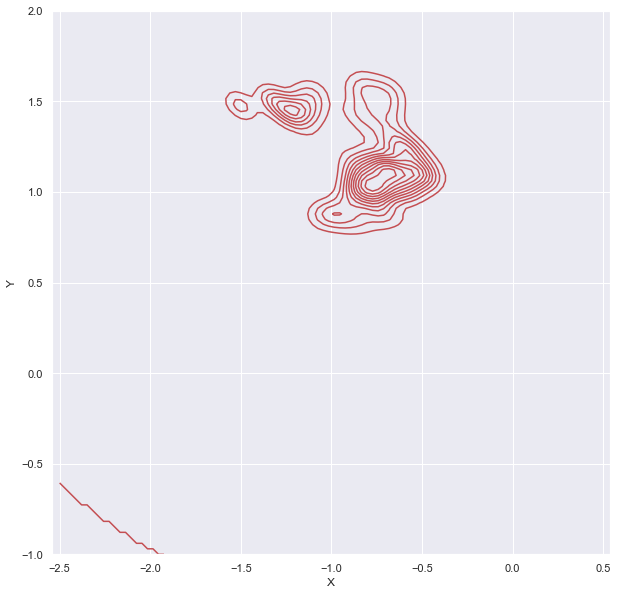

In [6]:

pair = test.pair_data_ref()
print(pair)
test_syn = Syn_Position(test_data_path, pair[0][0], pair[0][1], ref_suffix='ref')
test_syn.contour_plot()

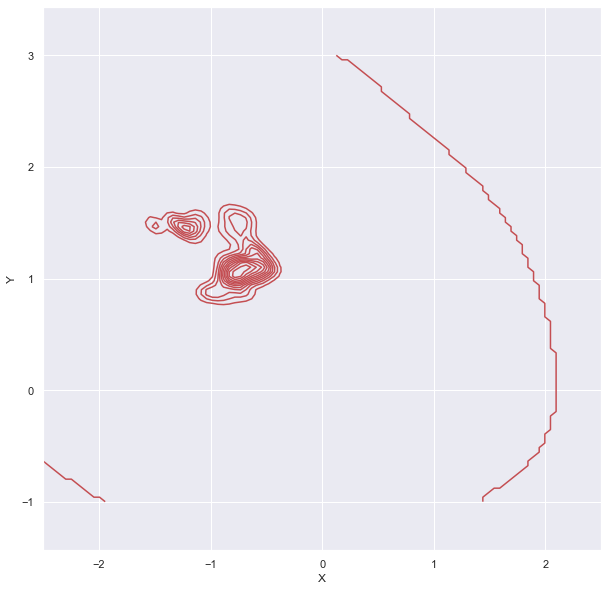

In [7]:
test_syn.contour_plot(xmin=-2.5, xmax=2.5, ymax=3.0,one_side=False, exp=True)

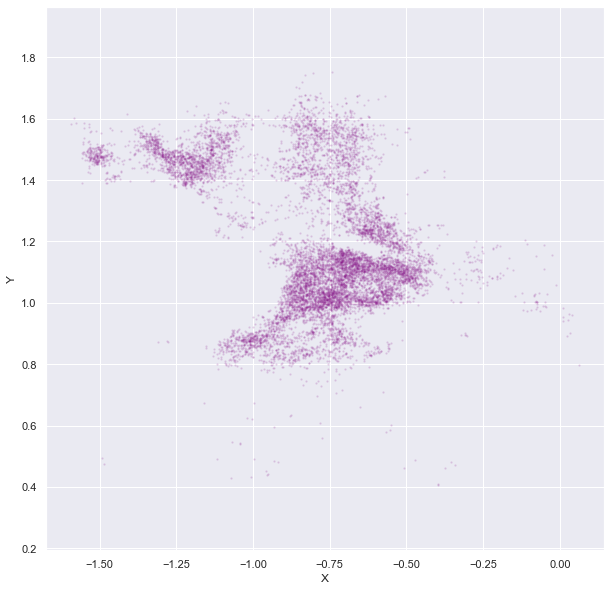

In [8]:
test_syn.scatter_plot(xmin=-2.5, xmax=3.5, ymax=3.0, one_side=False, exp=True)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass bandwidth=0.1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
H:\Synapses_position_analysis_wz_nor_201208_USE.py:340: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde.fit(x[:, None])


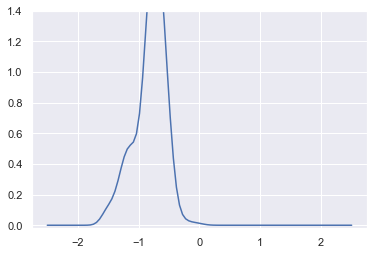

In [9]:
test_syn.kde1d_x_plot(xmin=-2.5, xmax=2.5, one_side=False, exp=True)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass bandwidth=0.1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
H:\Synapses_position_analysis_wz_nor_201208_USE.py:356: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde.fit(y[:, None])


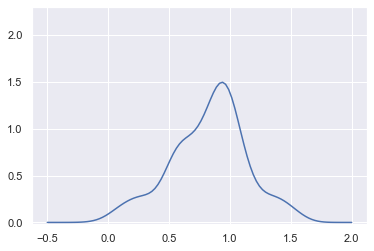

In [32]:
test_syn.kde1d_y_plot(ymin=-0.5, ymax=2)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass bandwidth=0.1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
H:\Synapses_position_analysis_wz_nor_201208_USE.py:356: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde.fit(y[:, None])


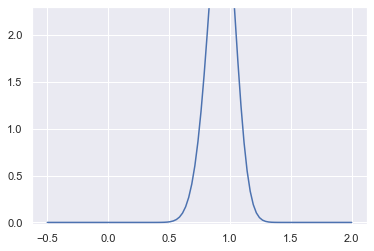

In [10]:
test_syn.kde1d_y_plot(ymin=-0.5, ymax=2, one_side=True,  contra_side=True, exp=True)

In [11]:
test_syn.split_data(one_side=True,  contra_side=True)

(              x           y
 4093  61.666493  797.691003
 4094  11.453670  941.831676
 4095  34.870254  900.483285
 4101  38.191751  960.180268
 6707  27.142025  945.125130
 6708  24.232883  892.642444
 6712  12.078023  981.377043
 9062  28.694019  964.478029
 9063  10.456363  953.965443,
 'one_side')

In [20]:
syn_test_1 = Syn_Position(test_data_path, 'test_nor.xls')
syn_test_1.contour_plot(xmax=1,ymin=-3)

IndexError: list index out of range

In [21]:
syn_test_1.scatter_plot()

IndexError: list index out of range

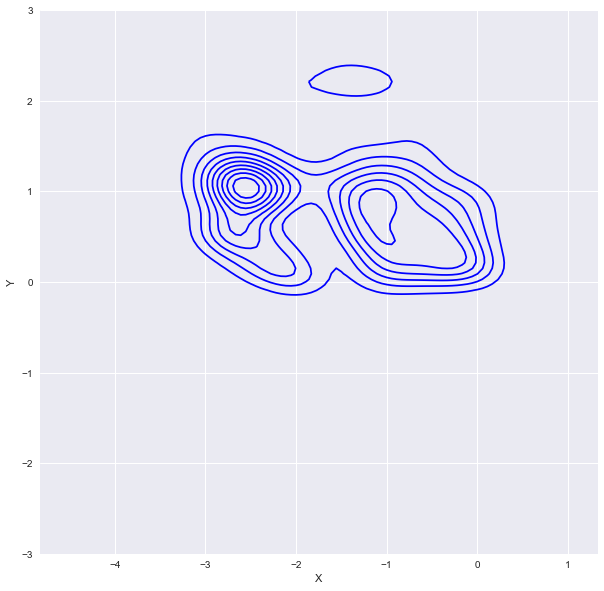

In [7]:
syn_MTX1_1_from_raw = Syn_Position(r'U:\RG Arber\Microscopy\Wuzhou\Final dataset\Syn_PCRt\origin\done', '20171125-MTX1-1_s6_10_max.xls', '20171125-MTX1-1_s6_10_ref.xls')
syn_MTX1_1_from_raw.contour_plot(xmax=1,ymin=-3)

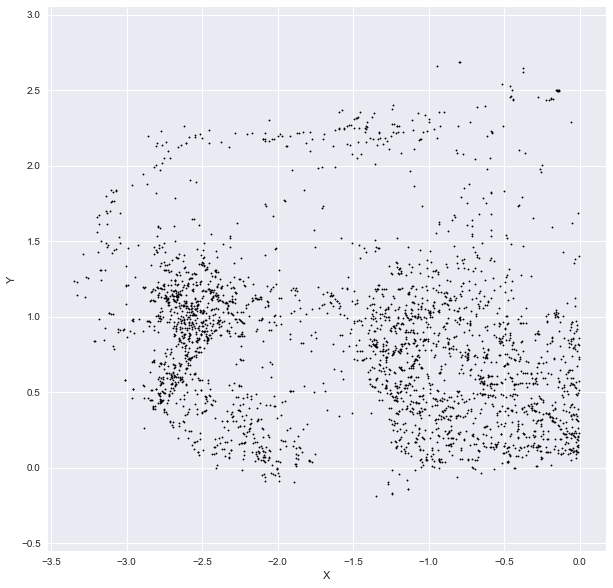

In [8]:
syn_MTX1_1_from_raw.scatter_plot()